# Imports 🎈

Добавление всех необходимых библиотек и формирование requerments.txt

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2 
import datetime

from typing import Tuple, List
import matplotlib.patches as patches
from tqdm import tqdm

%pylab inline
plt.style.use("bmh")
plt.rc('font', size=14)

Populating the interactive namespace from numpy and matplotlib


# Выбор ночных кадров 🎇

In [2]:
base_path = "data/kazan_cam/"
data_table = pd.DataFrame(columns=("file",))

for dirpath, _, filenames in os.walk(base_path):
    for file_name in filenames:
        if file_name.split(".")[-1] != "txt" and file_name.split(".")[-1] != "zip":
            file_path = os.path.join(dirpath, file_name)
            data_table = data_table.append({"file": file_path.replace("\\", "/")}, ignore_index=True)
        
data_table.head()

,file
0,data/kazan_cam/0/23-11-2021_10-56-29_PM.jpg
1,data/kazan_cam/0/23-11-2021_11-14-23_PM.jpg
2,data/kazan_cam/0/23-11-2021_11-32-06_PM.jpg
3,data/kazan_cam/0/23-11-2021_11-49-58_PM.jpg
4,data/kazan_cam/0/24-11-2021_01-01-02_AM.jpg


In [3]:
data_table["time"] = data_table["file"].str.split("/").str[-1].str.split(".").str[0]
data_table["time"] = pd.to_datetime(data_table["time"], format='%d-%m-%Y_%I-%M-%S_%p')

Ночное время: 00 до 04

In [4]:
edge = datetime.datetime.strptime('04:00', '%H:%M').time()
data_table = data_table[data_table["time"].dt.time < edge]
data_table = data_table.reset_index(drop=True)
data_table["cam"] = data_table["file"].str.split("cam/").str[1].str.split("/").str[0].astype(int)
print("Уникальных ночных камер в датасете:", data_table["cam"].nunique())

Уникальных ночных камер в датасете: 54


# Выделение фонарей🎮
* среднее от всех ночных снимков
* выделение фоноря

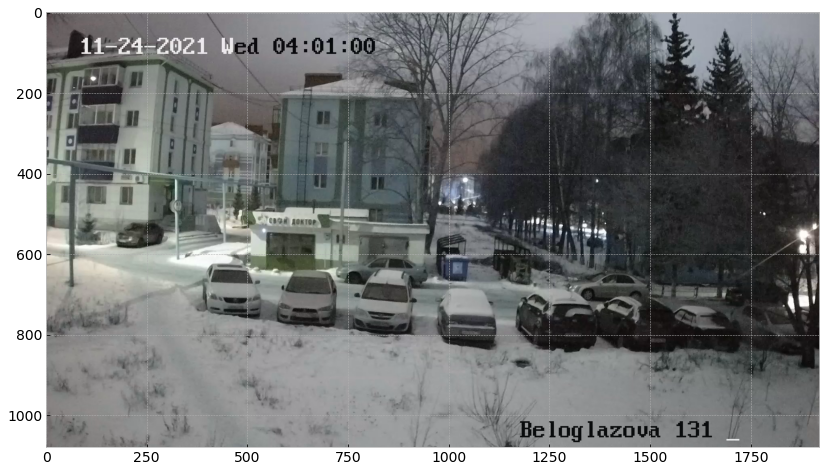

In [24]:
temp_img = cv2.imread(data_table.iloc[0, 0])
plt.figure(figsize=(15,8))
plt.imshow(temp_img)
plt.show()

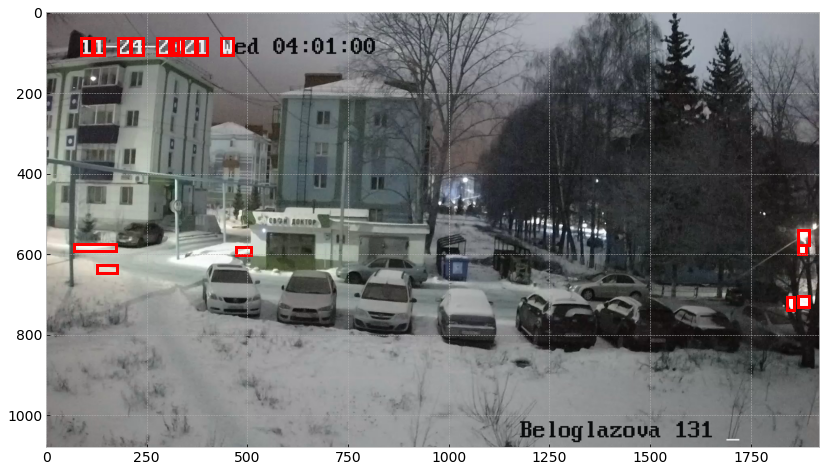

In [34]:
gray = cv2.cvtColor(temp_img, cv2.COLOR_BGR2GRAY)
ret,gray = cv2.threshold(gray, 220, 255, cv2.THRESH_BINARY_INV)
contours, hier = cv2.findContours(gray,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

fig, ax = plt.subplots(1, figsize=(15,8))
ax.imshow(temp_img)

for cnt in contours:
    if 250 < cv2.contourArea(cnt) < 1000:
        (x,y,w,h) = cv2.boundingRect(cnt)
        rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

plt.show()

In [41]:
def get_bboxes(img_name:str) -> list:
    img = cv2.imread(img_name)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, gray = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
    contours, hier = cv2.findContours(gray,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    bbox = []
    for cnt in contours:
        if 250 < cv2.contourArea(cnt) < 1000:
            (x,y,w,h) = cv2.boundingRect(cnt)
            bbox.append((x, y, w, h))
    return bbox

In [42]:
#Получаем всю разметку
data_table["auto_bboxes"] = None
for i in tqdm(data_table.index):
    bbox = get_bboxes(data_table.loc[i, "file"])
    data_table.at[i, "auto_bboxes"] = bbox
    
data_table.head()

100%|████████████████████████████████████████████████████████████████████████████████| 747/747 [00:31<00:00, 23.85it/s]


,file,time,cam,auto_bboxes
0,data/kazan_cam/0/24-11-2021_01-01-02_AM.jpg,2021-11-24 01:01:02,0,"[(1840, 704, 18, 36), (1867, 702, 27, 30), (58..."
1,data/kazan_cam/0/24-11-2021_01-18-48_AM.jpg,2021-11-24 01:18:48,0,"[(1495, 1027, 30, 30), (1467, 1027, 26, 30), (..."
2,data/kazan_cam/0/24-11-2021_01-36-38_AM.jpg,2021-11-24 01:36:38,0,"[(1495, 1027, 30, 30), (1467, 1027, 26, 30), (..."
3,data/kazan_cam/0/24-11-2021_01-54-32_AM.jpg,2021-11-24 01:54:32,0,"[(1840, 704, 18, 34), (1867, 702, 27, 30), (39..."
4,data/kazan_cam/0/24-11-2021_02-12-21_AM.jpg,2021-11-24 02:12:21,0,"[(1627, 1015, 26, 42), (1839, 704, 19, 34), (1..."


file number:110


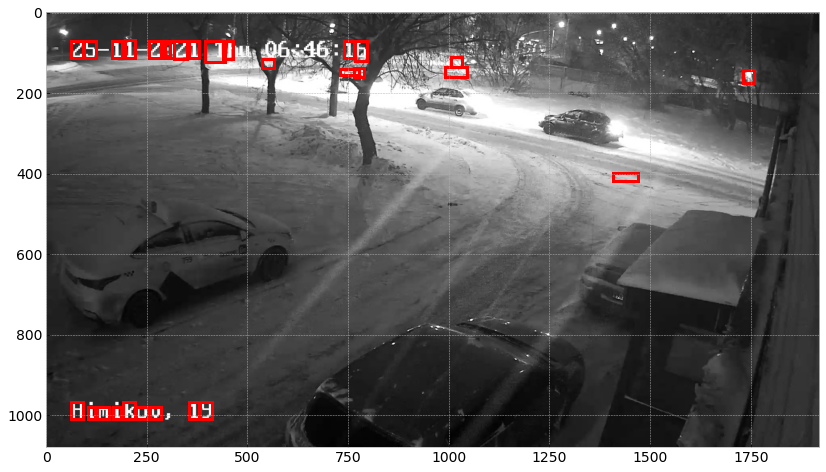

In [43]:
idx = input("file number:")
idx = int(idx)
fig, ax = plt.subplots(1, figsize=(15,8))
ax.imshow(Image.open(data_table.iloc[idx, 0]))

for cnt in data_table.iloc[idx]["auto_bboxes"]:
    (x,y,w,h) = cnt
    rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

# 2 Подход - выделяем руками по камерам
Камеры статичны $\rightarrow$ можно выделить область с запасом для каждой камеры, а затем по ней проверять

In [46]:
labels = {
    0 : [(1865, 532, 34, 37), (1031, 400, 23, 25)],
    1 : [(531, 210, 36, 29), (795, 146, 33, 37), (877, 49, 23, 27), (969, 47, 40, 40), (1177, 179, 35, 35)],
    2 : None,
    4 : [(1590, 673, 101, 79), (40, 407, 51, 50)],
    5 : None,
    6 : [(863, 81, 63, 61)],
    7 : None,
    8 : None,
    9 : [(1237, 101, 120, 110), (1103, 87, 75, 91), (667, 201, 45, 29)],
    10: [(1577, 221, 49, 51), (927, 313, 37, 35), (272, 437, 45, 41)],
    11: None,
    12: [(1707, 67, 61, 59), (309, 135, 44, 44), (751, 119, 30, 30), (1467, 56, 34, 34)],
    13: [(274, 24, 60, 42), (15, 85, 46, 52)],
    14: None,
    15: [(1052, 342, 44, 35), (320, 332, 36, 31), (138, 370, 26, 26)],
    16: None,
    17: None,
    18: [(21, 25, 45, 45), (693, 25, 40, 40), (1259, 15, 40, 40), (1400, 22, 30,30), (1311, 48, 31, 26), (1360, 33, 22, 30), (1733, 125, 46,50)],
    20: [(456, 16, 44, 36)],
    21: [(254, 15, 47, 33), (1000, 56, 27, 21), (568, 3, 27, 26), (684, 1, 32, 24), (1822, 186, 31, 37), (1310, 53, 23, 21), (1178, 63, 26, 19), (1242, 70, 22, 20), (1343, 56, 20, 20), (1393, 81, 22, 22), (1418, 92, 20,20)],
    22: [(90, 118, 33, 22), (127, 106, 22, 31), (545, 141, 26, 28), (858, 141, 23, 20), (984, 147, 16, 16), (948, 181, 20, 20), (968, 180, 20, 20), (115, 194, 20, 20), (1224, 30, 23, 23), (1249, 23, 20, 20), (1277, 27, 25, 25)],
    23: [(180, 60, 28, 25), (297, 33, 26, 26), (398, 4, 35, 35), (531, 0, 39, 31)],
    25: [(26, 86, 31, 36)],
    26: [(398, 180, 32, 24), (453, 120, 40, 38), (543, 118, 25, 30), (985, 105, 23, 27), (1132, 41, 50, 47), (1345, 43, 34, 32), (1230, 63, 33, 35), (1825, 72, 26, 24), (2318, 148, 27, 30), (2485, 190, 26, 27), (2526, 180, 50, 45)],
    27: None,
    28: [(826, 87, 32, 35), (1479, 106, 22, 23), (1998, 173, 13, 18), (2170, 197, 20, 17), (1924, 130, 15, 15)],
    29: None,
    30: [(297, 28, 20, 20), (174, 86, 25, 20), (149, 112, 25, 20)],
    31: None,
    32: [(1588, 11, 38, 30), (1924, 95, 25, 25)],
    33: [(73, 35, 35, 35)],
    34: [(1337, 27, 77, 65), (501, 21, 57, 39), (401, 41, 39, 37), (190, 59, 25, 20), (325, 72, 22, 20)],
    35: None,
    36: [(179, 42, 44, 40)],
    37: None,
    38: None,
    39: None,
    40: None,
    41: None,
    42: None,
    43: None,
    44: [(163, 163, 27, 27), (623, 50, 22, 22), (730, 35, 20, 20), (1241, 33, 25, 25)],
    45: [(439, 279, 35, 35)],
    46: [(1693, 129, 57, 57)],
    47: None,
    48: None,
    49: None,
    50: None
}

In [64]:
data_table["manual_bboxes"] = None
for key, value in labels.items():
    temp_idx = list(data_table[data_table["cam"] == key].index)
    for i in temp_idx:
        data_table.at[i, "manual_bboxes"] = value

file number:200


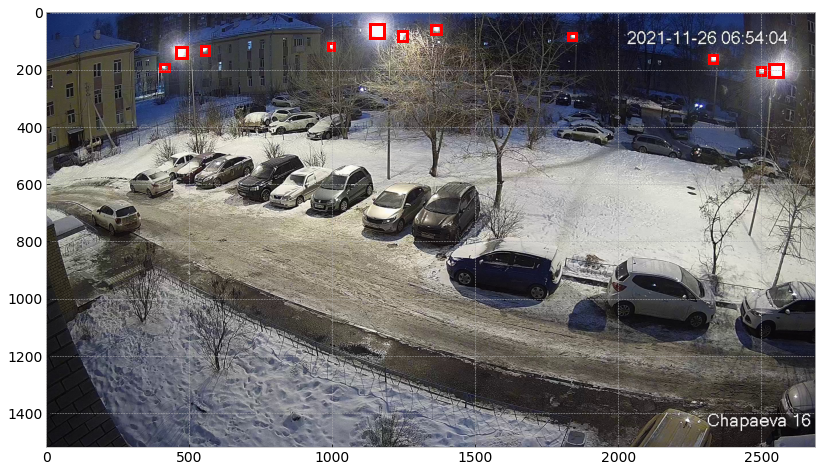

In [66]:
idx = input("file number:")
idx = int(idx)
fig, ax = plt.subplots(1, figsize=(15,8))
ax.imshow(Image.open(data_table.iloc[idx, 0]))

if data_table.iloc[idx]["manual_bboxes"] is not None:
    for cnt in data_table.iloc[idx]["manual_bboxes"]:
        (x,y,w,h) = cnt
        rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

plt.show()

# Анализ линейной разделимости
* проверить средние значения в дневное/ночное время (работает и нет) по отношению к обзей освещенности
* построить графики
* если работает - найти границу разделения

In [98]:
data_table = data_table.dropna()
data_table = data_table.reset_index(drop=True)

In [99]:
data_day = pd.DataFrame(columns=("file",))

for dirpath, _, filenames in os.walk(base_path):
    for file_name in filenames:
        if file_name.split(".")[-1] != "txt" and file_name.split(".")[-1] != "zip":
            file_path = os.path.join(dirpath, file_name)
            data_day = data_day.append({"file": file_path.replace("\\", "/")}, ignore_index=True)
        
data_day["time"] = data_day["file"].str.split("/").str[-1].str.split(".").str[0]
data_day["time"] = pd.to_datetime(data_day["time"], format='%d-%m-%Y_%I-%M-%S_%p')
start_edge = datetime.datetime.strptime('11:00', '%H:%M').time()
end_edge = datetime.datetime.strptime('17:00', '%H:%M').time()
data_day = data_day[(data_day["time"].dt.time > start_edge) & (data_day["time"].dt.time < end_edge)]
data_day = data_day.reset_index(drop=True)
data_day["cam"] = data_day["file"].str.split("cam/").str[1].str.split("/").str[0].astype(int)
data_day = data_day[data_day["cam"].isin(data_table["cam"].unique())]
data_day["manual_bboxes"] = None
for key, value in labels.items():
    temp_idx = list(data_day[data_day["cam"] == key].index)
    for i in temp_idx:
        data_day.at[i, "manual_bboxes"] = value

In [102]:
data_table = data_table[data_table["cam"].isin(data_day["cam"].unique())]
data_table["cam"].nunique(), data_day["cam"].nunique()

(24, 24)

In [103]:
def get_relative_bright(img_name:str, bboxes:List[tuple]) -> List[float]:
    img = np.asarray(Image.open(img_name))
    mean_bright = img.mean()
    lights = []
    for i in bboxes:
        x, y, w, h = i
        lights.append(img[y:y+h, x:x+w].mean() / mean_bright)
    return lights

In [104]:
# Распределение яркостей в ночное время
temp_data = data_table.drop_duplicates(subset=["cam"])
lights = []
for i in range(len(temp_data)):
    temp = get_relative_bright(temp_data.iloc[i, 0], temp_data.iloc[i, -1])
    lights.extend(temp)

print("Уникальных фонарей [единовременно]:", len(lights))

Уникальных фонарей [единовременно]: 91


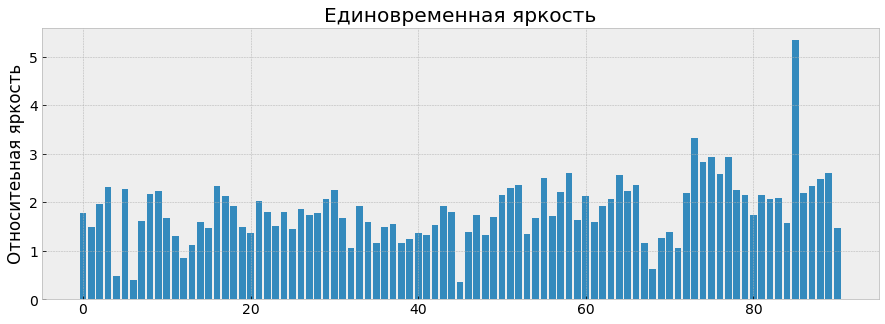

In [105]:
plt.figure(figsize=(15, 5))
plt.bar([x for x in range(len(lights))], lights)
plt.ylabel("Относитеьная яркость")
plt.title("Единовременная яркость")
plt.show()

In [106]:
weight_lights = []
for cam in tqdm(data_table["cam"].unique()):
    temp_data = data_table[data_table["cam"] == cam].copy()
    temp_light = []
    for i in range(len(temp_data)):
        temp = get_relative_bright(temp_data.iloc[i, 0], temp_data.iloc[i, -1])
        temp_light.append(temp)
    temp_light = np.mean(np.asarray(temp_light), axis=0)
    weight_lights.extend(temp_light.tolist())

print("Уникальных фонарей [единовременно]:", len(weight_lights))

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:09<00:00,  2.63it/s]

Уникальных фонарей [единовременно]: 91


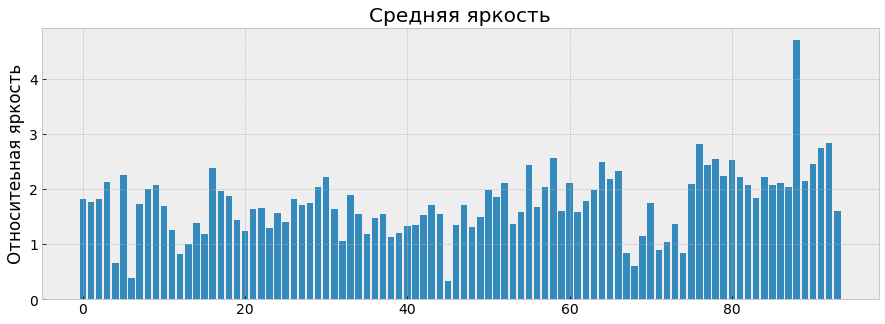

In [86]:
plt.figure(figsize=(15, 5))
plt.bar([x for x in range(len(weight_lights))], weight_lights)
plt.ylabel("Относитеьная яркость")
plt.title("Средняя яркость")
plt.show()

Сравним с дневным временем

In [107]:
weight_day_lights = []
for cam in tqdm(data_day["cam"].unique()):
    temp_data = data_day[data_day["cam"] == cam].copy()
    temp_light = []
    for i in range(len(temp_data)):
        temp = get_relative_bright(temp_data.iloc[i, 0], temp_data.iloc[i, -1])
        temp_light.append(temp)
    temp_light = np.mean(np.asarray(temp_light), axis=0)
    weight_day_lights.extend(temp_light.tolist())

print("Уникальных фонарей [единовременно]:", len(weight_day_lights))

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:09<00:00,  2.62it/s]

Уникальных фонарей [единовременно]: 91


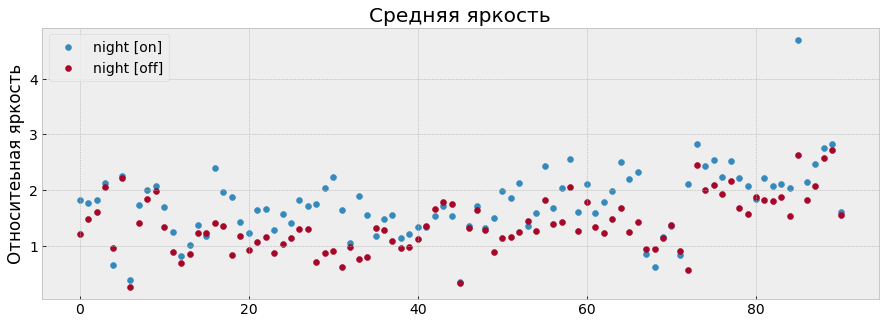

In [108]:
plt.figure(figsize=(15, 5))
plt.scatter([x for x in range(len(weight_lights))], weight_lights, label="night [on]")
plt.scatter([x for x in range(len(weight_day_lights))], weight_day_lights, label="night [off]")
plt.legend(loc="best")
plt.ylabel("Относитеьная яркость")
plt.title("Средняя яркость")
plt.show()

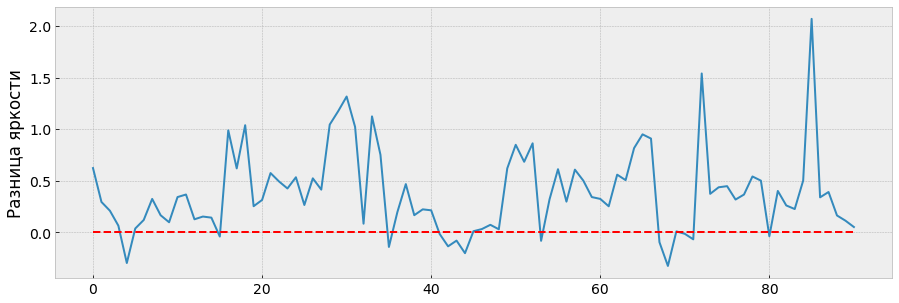

In [113]:
plt.figure(figsize=(15, 5))
plt.plot(np.asarray(weight_lights) - np.asarray(weight_day_lights))
plt.plot([0 for x in range(len(weight_lights))], "r--")
plt.ylabel("Разница яркости")
plt.show()

Таким образом делаем вывод о линейной разделимости ночного и дневного состаяния фонарей, что более строгое ограничение чем различимость ночного рабочего и не рабочего состояния. Так как разделимость линейная - модель может быть масштабирована на большое количество камер и фонарей.